In [1]:
%matplotlib inline

import os

import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import sklearn.utils, sklearn.preprocessing, sklearn.decomposition, sklearn.svm
import librosa
import librosa.display
import missingno as msno

import utils

plt.rcParams['figure.figsize'] = (17, 5)

In [2]:
# Directory where mp3 are stored.
AUDIO_DIR = 'data/fma_small'

# Load metadata and features.
tracks = utils.load('data/fma_metadata/tracks.csv')
genres = utils.load('data/fma_metadata/genres.csv')
features = utils.load('data/fma_metadata/features.csv')
echonest = utils.load('data/fma_metadata/echonest.csv')

np.testing.assert_array_equal(features.index, tracks.index)
assert echonest.index.isin(tracks.index).all()

tracks.shape, genres.shape, features.shape, echonest.shape

((106574, 52), (163, 4), (106574, 518), (13129, 249))

In [3]:
tracks.head()

album                                                          \
         comments        date_created date_released engineer favorites id   
track_id                                                                    
2               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
3               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
5               0 2008-11-26 01:44:45    2009-01-05      NaN         4  1   
10              0 2008-11-26 01:45:08    2008-02-06      NaN         4  6   
20              0 2008-11-26 01:45:05    2009-01-06      NaN         2  4   

                                                                           \
                                        information listens producer tags   
track_id                                                                    
2                                           <p></p>    6073      NaN   []   
3                                           <p></p>    6073      NaN   []   
5                                           <p></p>    6073      NaN   []   
10                                              NaN   47632      NaN   []   
20        <p> "spiritual songs" from Nicky Cook</p>    2710      NaN   []   

          ...       track                         \
          ... information interest language_code   
track_id  ...                                      
2         ...         NaN     4656            en   
3         ...         NaN     1470            en   
5         ...         NaN     1933            en   
10        ...         NaN    54881            en   
20        ...         NaN      978            en   

                                                                              \
                                                    license listens lyricist   
track_id                                                                       
2         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1293      NaN   
3         Attribution-NonCommercial-ShareAlike 3.0 Inter...     514      NaN   
5         Attribution-NonCommercial-ShareAlike 3.0 Inter...    1151      NaN   
10        Attribution-NonCommercial-NoDerivatives (aka M...   50135      NaN   
20        Attribution-NonCommercial-NoDerivatives (aka M...     361      NaN   

                                                 
         number publisher tags            title  
track_id                                         
2             3       NaN   []             Food  
3             4       NaN   []     Electric Ave  
5             6       NaN   []       This World  
10            1       NaN   []          Freeway  
20            3       NaN   []  Spiritual Level  

[5 rows x 52 columns]

In [4]:
tracks.columns = tracks.columns.map('_'.join)
tracks = tracks.reset_index()

In [5]:
tracks.columns

Index(['track_id', 'album_comments', 'album_date_created',
       'album_date_released', 'album_engineer', 'album_favorites', 'album_id',
       'album_information', 'album_listens', 'album_producer', 'album_tags',
       'album_title', 'album_tracks', 'album_type', 'artist_active_year_begin',
       'artist_active_year_end', 'artist_associated_labels', 'artist_bio',
       'artist_comments', 'artist_date_created', 'artist_favorites',
       'artist_id', 'artist_latitude', 'artist_location', 'artist_longitude',
       'artist_members', 'artist_name', 'artist_related_projects',
       'artist_tags', 'artist_website', 'artist_wikipedia_page', 'set_split',
       'set_subset', 'track_bit_rate', 'track_comments', 'track_composer',
       'track_date_created', 'track_date_recorded', 'track_duration',
       'track_favorites', 'track_genre_top', 'track_genres',
       'track_genres_all', 'track_information', 'track_interest',
       'track_language_code', 'track_license', 'track_listens',
  

In [6]:
#filter tracks.csv for subset==small 
tracks_medium = tracks[tracks['set_subset'] <= 'medium']

<Axes: >

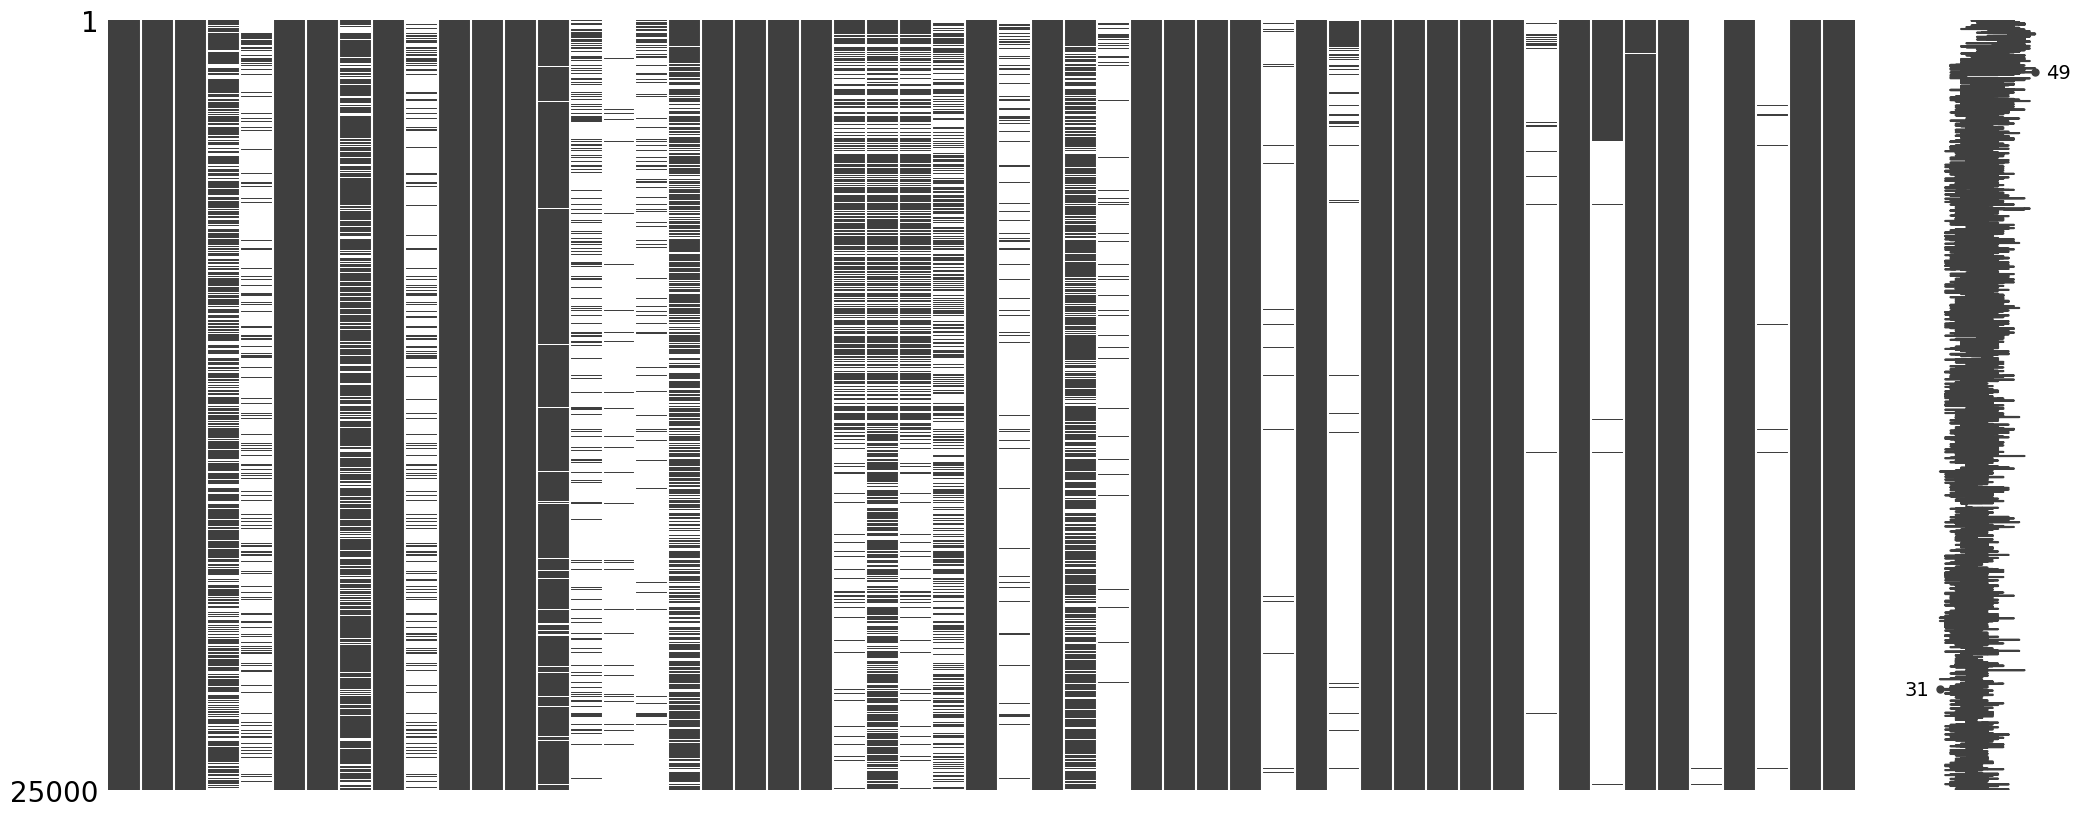

In [7]:
msno.matrix(tracks_medium)

In [8]:
tracks_medium.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25000 entries, 0 to 106567
Data columns (total 53 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   track_id                  25000 non-null  int64         
 1   album_comments            25000 non-null  int64         
 2   album_date_created        25000 non-null  datetime64[ns]
 3   album_date_released       17092 non-null  datetime64[ns]
 4   album_engineer            4493 non-null   object        
 5   album_favorites           25000 non-null  int64         
 6   album_id                  25000 non-null  int64         
 7   album_information         20284 non-null  category      
 8   album_listens             25000 non-null  int64         
 9   album_producer            4976 non-null   object        
 10  album_tags                25000 non-null  object        
 11  album_title               25000 non-null  object        
 12  album_tracks          

In [9]:
print(f"numbers of rows : {tracks_medium.shape[0]}")
for index, col in enumerate(tracks_medium.columns):
    if tracks_medium[col].isna().sum() != 0:
        print(f"missing values in {index} - {col} : {round(tracks_medium[col].isna().sum()/tracks_medium.shape[0]*100,2)} %")

print(f"missing values in data frame : {round(tracks_medium.isna().sum().sum()/(tracks_medium.shape[0]*tracks_medium.shape[1])*100,2)} %")

numbers of rows : 25000
missing values in 3 - album_date_released : 31.63 %
missing values in 4 - album_engineer : 82.03 %
missing values in 7 - album_information : 18.86 %
missing values in 9 - album_producer : 80.1 %
missing values in 13 - album_type : 2.65 %
missing values in 14 - artist_active_year_begin : 81.16 %
missing values in 15 - artist_active_year_end : 95.56 %
missing values in 16 - artist_associated_labels : 88.99 %
missing values in 17 - artist_bio : 30.03 %
missing values in 22 - artist_latitude : 60.23 %
missing values in 23 - artist_location : 32.08 %
missing values in 24 - artist_longitude : 60.23 %
missing values in 25 - artist_members : 55.73 %
missing values in 27 - artist_related_projects : 91.14 %
missing values in 29 - artist_website : 21.64 %
missing values in 30 - artist_wikipedia_page : 94.54 %
missing values in 35 - track_composer : 97.65 %
missing values in 37 - track_date_recorded : 93.05 %
missing values in 43 - track_information : 97.3 %
missing values 

In [10]:
#Impute with Mode
medium_tracks_features = tracks_medium.copy()
medium_tracks_features['track_license'].fillna(tracks['track_license'].mode()[0], inplace=True)

In [11]:
#Impute with Mode
medium_tracks_features['album_type'].fillna(medium_tracks_features['album_type'].mode()[0], inplace=True)

In [12]:
medium_tracks_features['track_license'].isna().value_counts()
medium_tracks_features['album_type'].isna().value_counts()

album_type
False    25000
Name: count, dtype: int64

#### Treatment of artist_website column

Fill NA with False

In [13]:
#fill na with 0 = artist has no website --> this is an assumption we make
medium_tracks_features['artist_website'].fillna(0, inplace=True)
#convert column to string dtype
medium_tracks_features['artist_website'] = medium_tracks_features['artist_website'].astype('string')

In [14]:
medium_tracks_features['artist_website'].info()

<class 'pandas.core.series.Series'>
Index: 25000 entries, 0 to 106567
Series name: artist_website
Non-Null Count  Dtype 
--------------  ----- 
25000 non-null  string
dtypes: string(1)
memory usage: 390.6 KB


In [15]:
#quick statistics how many tracks have soundcloud / bandcamp websites
soundcloud = medium_tracks_features[medium_tracks_features['artist_website'].str.contains('soundcloud.com', na=False)].shape[0]
bandcamp = medium_tracks_features[medium_tracks_features['artist_website'].str.contains('bandcamp.com', na=False)].shape[0]

print(f'{soundcloud} rows are soundcloud artist websites')
print(f'{bandcamp} rows are bandcamp artist websites')
print(f'This is {round(((soundcloud + bandcamp) / len(medium_tracks_features)) * 100, 2)} % of all rows')

1169 rows are soundcloud artist websites
2554 rows are bandcamp artist websites
This is 14.89 % of all rows


Creating the new column has_soundcloud_or_bandcamp

In [16]:
medium_tracks_features['artist_website'].info()

<class 'pandas.core.series.Series'>
Index: 25000 entries, 0 to 106567
Series name: artist_website
Non-Null Count  Dtype 
--------------  ----- 
25000 non-null  string
dtypes: string(1)
memory usage: 390.6 KB


In [17]:
# create new column website_type
medium_tracks_features['website_type'] = medium_tracks_features['artist_website'].apply(
    lambda x: 'soundcloud' if 'soundcloud.com' in x else ('bandcamp' if 'bandcamp.com' in x else 'other_website' if x else 'none'))


In [18]:
# drop artist_website column
medium_tracks_features.drop('artist_website', axis=1)

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,track_interest,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title,website_type
0,2,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,...,4656,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food,other_website
1,3,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,...,1470,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave,other_website
2,5,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,...,1933,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World,other_website
3,10,0,2008-11-26 01:45:08,2008-02-06,NaN,4,6,NaN,47632,NaN,...,54881,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway,other_website
9,134,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,...,1126,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,943,NaN,5,NaN,[],Street Music,other_website
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106551,155297,0,2017-03-30 09:50:32,2017-03-30,NaN,1,22935,<p>The stars will show you the way in this unp...,6196,NaN,...,1463,NaN,Attribution-NonCommercial,1049,NaN,9,NaN,[],Nebula Reborn,other_website
106552,155298,0,2017-03-30 10:45:13,NaT,NaN,0,22936,NaN,2454,NaN,...,706,NaN,Attribution,590,NaN,2,NaN,[],An Idiot Abroad,soundcloud
106560,155306,0,2017-03-30 10:45:13,NaT,NaN,0,22936,NaN,2454,NaN,...,497,NaN,Attribution,435,NaN,1,NaN,[],Tiny Man,soundcloud
106561,155307,0,2017-03-30 12:51:05,2017-03-27,Scott Williams,0,22937,<p>Scott welcomes Russian revolutionary avant ...,1206,Scott Williams,...,630,NaN,Creative Commons Attribution-NonCommercial-NoD...,571,NaN,1,NaN,[],Kolka,other_website


In [19]:
encoded_categories = pd.get_dummies(medium_tracks_features['website_type'], drop_first=True)
medium_tracks_features = pd.concat([medium_tracks_features, encoded_categories], axis=1)
medium_tracks_features.drop('website_type', axis=1, inplace=True)
medium_tracks_features.head()

,track_id,album_comments,album_date_created,album_date_released,album_engineer,album_favorites,album_id,album_information,album_listens,album_producer,...,track_language_code,track_license,track_listens,track_lyricist,track_number,track_publisher,track_tags,track_title,other_website,soundcloud
0,2,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,...,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,NaN,3,NaN,[],Food,True,False
1,3,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,...,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,NaN,4,NaN,[],Electric Ave,True,False
2,5,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,...,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,NaN,6,NaN,[],This World,True,False
3,10,0,2008-11-26 01:45:08,2008-02-06,NaN,4,6,NaN,47632,NaN,...,en,Attribution-NonCommercial-NoDerivatives (aka M...,50135,NaN,1,NaN,[],Freeway,True,False
9,134,0,2008-11-26 01:44:45,2009-01-05,NaN,4,1,<p></p>,6073,NaN,...,en,Attribution-NonCommercial-ShareAlike 3.0 Inter...,943,NaN,5,NaN,[],Street Music,True,False


In [20]:
#One-Hot-Encoding
#In this cell we will turn string features containing text into a binary variable. 
#We assume that rows with NaN simply haven't got the respective feature, like bio or information.
#The original columns are dropped together with all other incomplete columns

# album_information, artist_bio
medium_tracks_features['album_information_bin'] = medium_tracks_features['album_information'].notnull().astype(int)
medium_tracks_features['artist_bio_bin'] = medium_tracks_features['artist_bio'].notnull().astype(int)

In [21]:
# Drop all columns with missing values > 80% or which are simply not interesting or difficult to impute
medium_tracks_features.drop(['artist_location', 'album_date_released', 'album_engineer', 'album_producer', 'artist_active_year_begin', 
                         'artist_active_year_end', 'artist_associated_labels', 'artist_latitude', 'artist_longitude', 
                         'artist_members', 'artist_related_projects', 'artist_wikipedia_page', 'track_composer', 'track_date_recorded', 
                         'track_information', 'track_language_code', 'track_lyricist', 'track_publisher', 'album_tags', 'track_tags', 'album_information', 
                         'artist_bio', 'artist_website'], axis=1, inplace=True)

In [22]:
medium_tracks_features

,track_id,album_comments,album_date_created,album_favorites,album_id,album_listens,album_title,album_tracks,album_type,artist_comments,...,track_genres_all,track_interest,track_license,track_listens,track_number,track_title,other_website,soundcloud,album_information_bin,artist_bio_bin
0,2,0,2008-11-26 01:44:45,4,1,6073,AWOL - A Way Of Life,7,Album,0,...,[21],4656,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,3,Food,True,False,1,1
1,3,0,2008-11-26 01:44:45,4,1,6073,AWOL - A Way Of Life,7,Album,0,...,[21],1470,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,4,Electric Ave,True,False,1,1
2,5,0,2008-11-26 01:44:45,4,1,6073,AWOL - A Way Of Life,7,Album,0,...,[21],1933,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,6,This World,True,False,1,1
3,10,0,2008-11-26 01:45:08,4,6,47632,Constant Hitmaker,2,Album,3,...,[10],54881,Attribution-NonCommercial-NoDerivatives (aka M...,50135,1,Freeway,True,False,0,1
9,134,0,2008-11-26 01:44:45,4,1,6073,AWOL - A Way Of Life,7,Album,0,...,[21],1126,Attribution-NonCommercial-ShareAlike 3.0 Inter...,943,5,Street Music,True,False,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106551,155297,0,2017-03-30 09:50:32,1,22935,6196,Return,9,Album,0,...,"[107, 18, 1235]",1463,Attribution-NonCommercial,1049,9,Nebula Reborn,True,False,1,0
106552,155298,0,2017-03-30 10:45:13,0,22936,2454,Scissors Paper Stone,9,Album,0,...,"[17, 103]",706,Attribution,590,2,An Idiot Abroad,False,True,0,1
106560,155306,0,2017-03-30 10:45:13,0,22936,2454,Scissors Paper Stone,9,Album,0,...,"[17, 103]",497,Attribution,435,1,Tiny Man,False,True,0,1
106561,155307,0,2017-03-30 12:51:05,0,22937,1206,"Live at WFMU with Scott Williams, 3/27/2017",6,Live Performance,0,...,"[1, 38]",630,Creative Commons Attribution-NonCommercial-NoD...,571,1,Kolka,True,False,1,1


In [23]:
medium_tracks_features

,track_id,album_comments,album_date_created,album_favorites,album_id,album_listens,album_title,album_tracks,album_type,artist_comments,...,track_genres_all,track_interest,track_license,track_listens,track_number,track_title,other_website,soundcloud,album_information_bin,artist_bio_bin
0,2,0,2008-11-26 01:44:45,4,1,6073,AWOL - A Way Of Life,7,Album,0,...,[21],4656,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1293,3,Food,True,False,1,1
1,3,0,2008-11-26 01:44:45,4,1,6073,AWOL - A Way Of Life,7,Album,0,...,[21],1470,Attribution-NonCommercial-ShareAlike 3.0 Inter...,514,4,Electric Ave,True,False,1,1
2,5,0,2008-11-26 01:44:45,4,1,6073,AWOL - A Way Of Life,7,Album,0,...,[21],1933,Attribution-NonCommercial-ShareAlike 3.0 Inter...,1151,6,This World,True,False,1,1
3,10,0,2008-11-26 01:45:08,4,6,47632,Constant Hitmaker,2,Album,3,...,[10],54881,Attribution-NonCommercial-NoDerivatives (aka M...,50135,1,Freeway,True,False,0,1
9,134,0,2008-11-26 01:44:45,4,1,6073,AWOL - A Way Of Life,7,Album,0,...,[21],1126,Attribution-NonCommercial-ShareAlike 3.0 Inter...,943,5,Street Music,True,False,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106551,155297,0,2017-03-30 09:50:32,1,22935,6196,Return,9,Album,0,...,"[107, 18, 1235]",1463,Attribution-NonCommercial,1049,9,Nebula Reborn,True,False,1,0
106552,155298,0,2017-03-30 10:45:13,0,22936,2454,Scissors Paper Stone,9,Album,0,...,"[17, 103]",706,Attribution,590,2,An Idiot Abroad,False,True,0,1
106560,155306,0,2017-03-30 10:45:13,0,22936,2454,Scissors Paper Stone,9,Album,0,...,"[17, 103]",497,Attribution,435,1,Tiny Man,False,True,0,1
106561,155307,0,2017-03-30 12:51:05,0,22937,1206,"Live at WFMU with Scott Williams, 3/27/2017",6,Live Performance,0,...,"[1, 38]",630,Creative Commons Attribution-NonCommercial-NoD...,571,1,Kolka,True,False,1,1


In [24]:
#create new column with the number of characters for the tracks
medium_tracks_features['track_title_char_count'] = medium_tracks_features['track_title'].str.len()

In [25]:
medium_tracks_features['track_title_char_count'].describe()

count    25000.000000
mean        16.683800
std         11.437273
min          1.000000
25%          9.000000
50%         14.000000
75%         20.000000
max        152.000000
Name: track_title_char_count, dtype: float64

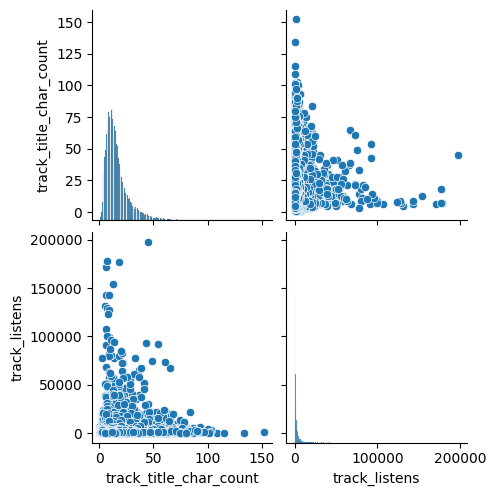

In [26]:
#short analysis to see relationship between length of track title and listens
medium_tracks_features_smaller_listens = medium_tracks_features[medium_tracks_features['track_listens'] <= 200000]
sns.pairplot(data=medium_tracks_features_smaller_listens[['track_title_char_count', 'track_listens']])

### Adding Echonest features

In [27]:
echonest.columns = echonest.columns.map('_'.join)
echonest = echonest.reset_index()

In [28]:
echonest

,track_id,echonest_audio_features_acousticness,echonest_audio_features_danceability,echonest_audio_features_energy,echonest_audio_features_instrumentalness,echonest_audio_features_liveness,echonest_audio_features_speechiness,echonest_audio_features_tempo,echonest_audio_features_valence,echonest_metadata_album_date,...,echonest_temporal_features_214,echonest_temporal_features_215,echonest_temporal_features_216,echonest_temporal_features_217,echonest_temporal_features_218,echonest_temporal_features_219,echonest_temporal_features_220,echonest_temporal_features_221,echonest_temporal_features_222,echonest_temporal_features_223
0,2,0.416675,0.675894,0.634476,0.010628,0.177647,0.159310,165.922,0.576661,NaN,...,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.676960,3.61288,13.316690,262.929749
1,3,0.374408,0.528643,0.817461,0.001851,0.105880,0.461818,126.957,0.269240,NaN,...,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.082770,6.01864,16.673548,325.581085
2,5,0.043567,0.745566,0.701470,0.000697,0.373143,0.124595,100.260,0.621661,NaN,...,-2.288358,11.527109,0.256821,0.237820,0.060122,0.06014,5.926490,5.86635,16.013849,356.755737
3,10,0.951670,0.658179,0.924525,0.965427,0.115474,0.032985,111.562,0.963590,2008-03-11,...,-3.662988,21.508228,0.283352,0.267070,0.125704,0.08082,8.414010,8.33319,21.317064,483.403809
4,134,0.452217,0.513238,0.560410,0.019443,0.096567,0.525519,114.290,0.894072,NaN,...,-1.452696,2.356398,0.234686,0.199550,0.149332,0.06440,11.267070,11.20267,26.454180,751.147705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13124,124857,0.007592,0.790364,0.719288,0.853114,0.720715,0.082550,141.332,0.890461,NaN,...,-1.721207,4.686078,0.213789,0.208800,0.007911,0.06395,2.040730,1.97678,8.144532,147.040405
13125,124862,0.041498,0.843077,0.536496,0.865151,0.547949,0.074001,101.975,0.476845,NaN,...,-0.647897,1.282306,0.214586,0.181860,0.011247,0.06240,0.922360,0.85996,1.794739,6.321268
13126,124863,0.000124,0.609686,0.895136,0.846624,0.632903,0.051517,129.996,0.496667,NaN,...,-0.771613,1.623510,0.180471,0.128185,0.010103,0.06222,2.251160,2.18894,5.578341,89.180328
13127,124864,0.327576,0.574426,0.548327,0.452867,0.075928,0.033388,142.009,0.569274,NaN,...,-2.054143,7.927149,0.250178,0.219205,0.014851,0.06390,1.487440,1.42354,2.173092,12.503966


In [29]:
#Intersection of medium dataset with echonest features
merged_medium_df_with_echonest = pd.merge(medium_tracks_features, echonest, how='inner', on=['track_id'])
merged_medium_df_with_echonest

,track_id,album_comments,album_date_created,album_favorites,album_id,album_listens,album_title,album_tracks,album_type,artist_comments,...,echonest_temporal_features_214,echonest_temporal_features_215,echonest_temporal_features_216,echonest_temporal_features_217,echonest_temporal_features_218,echonest_temporal_features_219,echonest_temporal_features_220,echonest_temporal_features_221,echonest_temporal_features_222,echonest_temporal_features_223
0,2,0,2008-11-26 01:44:45,4,1,6073,AWOL - A Way Of Life,7,Album,0,...,-1.992303,6.805694,0.233070,0.192880,0.027455,0.06408,3.67696,3.61288,13.316690,262.929749
1,3,0,2008-11-26 01:44:45,4,1,6073,AWOL - A Way Of Life,7,Album,0,...,-1.582331,8.889308,0.258464,0.220905,0.081368,0.06413,6.08277,6.01864,16.673548,325.581085
2,5,0,2008-11-26 01:44:45,4,1,6073,AWOL - A Way Of Life,7,Album,0,...,-2.288358,11.527109,0.256821,0.237820,0.060122,0.06014,5.92649,5.86635,16.013849,356.755737
3,10,0,2008-11-26 01:45:08,4,6,47632,Constant Hitmaker,2,Album,3,...,-3.662988,21.508228,0.283352,0.267070,0.125704,0.08082,8.41401,8.33319,21.317064,483.403809
4,134,0,2008-11-26 01:44:45,4,1,6073,AWOL - A Way Of Life,7,Album,0,...,-1.452696,2.356398,0.234686,0.199550,0.149332,0.06440,11.26707,11.20267,26.454180,751.147705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5276,124184,0,2015-08-26 12:43:03,0,18777,8593,Pseudologia Phantastica,3,Album,0,...,-3.198269,17.968399,0.216723,0.176190,0.040596,0.06358,5.52136,5.45778,17.432476,449.641266
5277,124185,0,2015-08-26 12:43:03,0,18777,8593,Pseudologia Phantastica,3,Album,0,...,-4.348511,40.269814,0.273623,0.264945,0.074076,0.06662,6.55338,6.48676,16.473083,362.156525
5278,124186,0,2015-08-26 12:43:03,0,18777,8593,Pseudologia Phantastica,3,Album,0,...,-2.688759,11.303486,0.328311,0.296350,0.085251,0.06417,4.51288,4.44871,7.614833,93.509598
5279,124397,0,2015-09-02 12:58:17,0,18801,18595,Antique Phonograph Music Program 04/14/2015,6,Album,0,...,-1.668249,7.022020,0.239019,0.182720,0.044364,0.06372,4.76703,4.70331,13.961578,289.356415


In [30]:
#check again which columns have nans
columns_with_nans = merged_medium_df_with_echonest.columns[merged_medium_df_with_echonest.isna().any()].tolist()
print(columns_with_nans)

#drop those columns: it is either information that we cannot use (due to them lying in future, e.g. rank), or they are available already
merged_medium_df_with_echonest.drop(columns_with_nans, axis=1, inplace=True)

['echonest_metadata_album_date', 'echonest_metadata_album_name', 'echonest_metadata_artist_latitude', 'echonest_metadata_artist_location', 'echonest_metadata_artist_longitude', 'echonest_ranks_artist_discovery_rank', 'echonest_ranks_artist_familiarity_rank', 'echonest_ranks_artist_hotttnesss_rank', 'echonest_ranks_song_currency_rank', 'echonest_ranks_song_hotttnesss_rank']


In [31]:
#Final check for missing values

if merged_medium_df_with_echonest.isna().any().any():
    print("DataFrame contains missing values.")
    # If you want to get a count of missing values in each column, you can use:
    missing_values_count = merged_medium_df_with_echonest.isna().sum()
    print("Number of missing values in each column:\n", missing_values_count)
else:
    print("DataFrame does not contain missing values.")

DataFrame does not contain missing values.


In [32]:
merged_medium_df_with_echonest.to_csv('data/medium_echonest_cleaned.csv')

#### Columns with lots of text - NLP module?

In [33]:
# Word cloud for 